In [1]:
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
current_dir = Path.cwd()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print('done')

done


In [3]:
from src.utils.save_data import save_df_parquet_safe, load_df_parquet_safe
from src.utils.plot_graphs import plot_beautiful, plot_dual_beautiful

In [4]:
# loading the master_df
path = project_root / 'data' / 'processed' / 'merge' / 'aligned_avw_merged.parquet'
avw_merged = load_df_parquet_safe(path=str(path))
avw_merged.head()

,Time,words,text_concat,h_ratio,v_ratio,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,...,mouthStretchRight,mouthUpperUpLeft,mouthUpperUpRight,noseSneerLeft,noseSneerRight,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent,speaker
0,0.0,"[We're, starting]",We're starting,0.463844,0.012997,3.112116e-06,0.015592,0.025971,0.023290,0.123947,...,0.000443,0.000025,0.000022,4.540787e-07,4.185384e-07,0.0373,0.00,0.00,False,None
1,0.5,"[now., [*]]",now. [*],0.418074,-0.048988,2.558370e-06,0.017408,0.037184,0.007811,0.137800,...,0.000918,0.000023,0.000030,2.511999e-07,3.643879e-07,0.0533,169.25,11.45,False,A
2,1.0,None,,0.465044,-0.030748,3.958608e-07,0.008864,0.010406,0.016732,0.179330,...,0.000332,0.000189,0.000269,2.899701e-06,1.134860e-07,0.0006,0.00,0.00,True,A
3,1.5,"[So, welcome]",So welcome,0.505119,-0.055033,3.260218e-07,0.012983,0.016629,0.008106,0.186212,...,0.000170,0.000070,0.000103,2.350217e-06,9.529118e-08,0.0593,179.94,14.03,False,A
4,2.0,"[to, the]",to the,0.590369,-0.050514,5.068692e-07,0.016363,0.028436,0.006705,0.117622,...,0.001666,0.000455,0.000476,4.304491e-06,2.317813e-07,0.0646,237.84,56.17,False,A


In [5]:
type(avw_merged.loc[avw_merged['speaker'] == 'B', 'words'])

pandas.core.series.Series

In [6]:
type(avw_merged['words'][0])

list

In [7]:
# total no of words
totalwords = 0
for words in avw_merged.loc[avw_merged['speaker'] == 'B', 'words']:
    if words and words != None:
        totalwords += len(words)
    else:
        continue

In [8]:
# let's count the filler words
cnt = 0
for words in avw_merged.loc[avw_merged['speaker'] == 'B', 'words']:
    if words and words != None:
        for word in words:
            if word == '[*]':
                cnt += 1
    else:
        continue

In [9]:
print(f"Total no of words used by the user: {totalwords}")

Total no of words used by the user: 1552


In [10]:
print(f"Total no of filler words by user: {cnt}")

Total no of filler words by user: 209


In [11]:
print(f"percentage of filler words: {(cnt/totalwords)*100}%")

percentage of filler words: 13.466494845360824%


I am trying to create a couple of features 1st one which keeps track of the filler words and one another this one keeps track of pauses.

In [12]:
# let's first make a copy of the dataframe
avw_merged_copy = avw_merged.copy()

In [13]:
avw_merged_copy.loc[avw_merged['speaker'] == 'B', 'words'].index

Index([  23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
       ...
       1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194],
      dtype='int64', length=1053)

In [14]:
# let's count the filler words
f_percent_pr = []
cnt = 0
for words in avw_merged_copy.loc[avw_merged['speaker'] == 'B', 'words']:
    if words and words != None:
        for word in words:
            if word == '[*]':
                cnt += 1        
        f_percent_pr.append((cnt/totalwords)*100)
    else:
        f_percent_pr.append((cnt/totalwords)*100)

In [15]:
f_percent_pr = pd.Series(f_percent_pr, name='filler_percentage')

In [16]:
f_percent_pr

0        0.064433
1        0.064433
2        0.064433
3        0.064433
4        0.064433
          ...    
1048    13.466495
1049    13.466495
1050    13.466495
1051    13.466495
1052    13.466495
Name: filler_percentage, Length: 1053, dtype: float64

In [17]:
avw_merged_copy.loc[avw_merged_copy.loc[avw_merged['speaker'] == 'B', 'words'].index, 'filler_percentage'] = f_percent_pr.values

In [18]:
avw_merged_copy['filler_percentage']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1259   NaN
1260   NaN
1261   NaN
1262   NaN
1263   NaN
Name: filler_percentage, Length: 1264, dtype: float64

In [19]:
avw_merged_copy['filler_percentage'].ffill(inplace=True)
avw_merged_copy['filler_percentage'].bfill(inplace=True)

In [20]:
avw_merged_copy['filler_percentage']

0        0.064433
1        0.064433
2        0.064433
3        0.064433
4        0.064433
          ...    
1259    13.466495
1260    13.466495
1261    13.466495
1262    13.466495
1263    13.466495
Name: filler_percentage, Length: 1264, dtype: float64

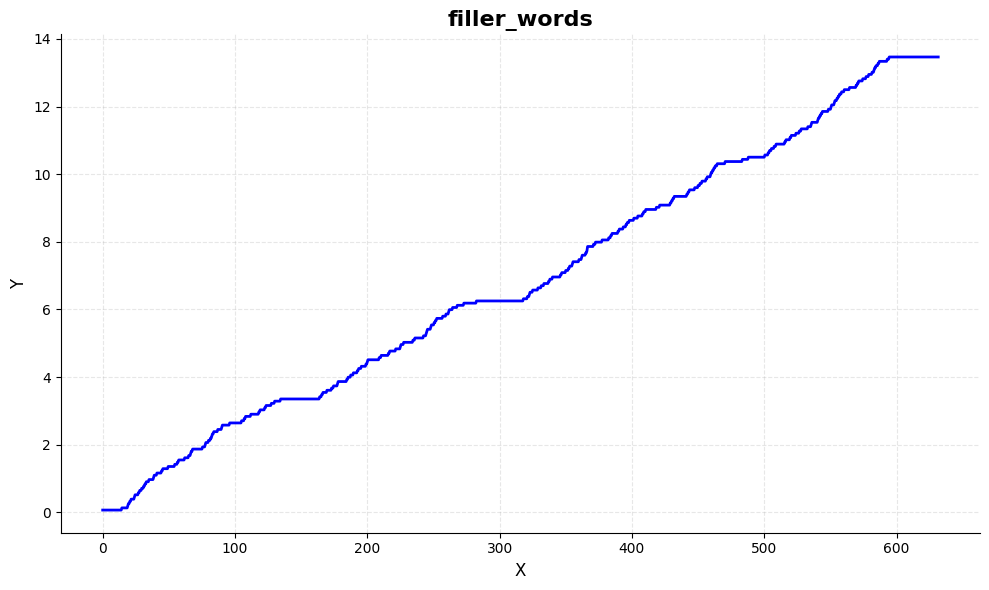

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'filler_words'}, xlabel='X', ylabel='Y'>)

In [21]:
plot_beautiful(x=avw_merged_copy['Time'], y=avw_merged_copy['filler_percentage'], title='filler_words')

I think we did it we created the first feature which was the filler percentage for the user and you can see how it increases with time

Let's move on to the next one, which is the pause_percentage calulation

In [22]:
avw_merged_copy['is_silent'].unique()

array([False,  True])

In [23]:
(avw_merged_copy['text_concat'] == '') & (avw_merged_copy['speaker'] == 'B')

0       False
1       False
2       False
3       False
4       False
        ...  
1259    False
1260    False
1261    False
1262    False
1263    False
Length: 1264, dtype: bool

In [24]:
pauses = avw_merged_copy.loc[(avw_merged_copy['text_concat'] == '') & (avw_merged_copy['speaker'] == 'B')]

In [25]:
pauses

,Time,words,text_concat,h_ratio,v_ratio,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,...,mouthUpperUpLeft,mouthUpperUpRight,noseSneerLeft,noseSneerRight,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent,speaker,filler_percentage
24,12.0,None,,0.728435,-0.142492,3.132464e-07,0.045179,0.040908,0.009608,0.118403,...,0.000126,0.000091,7.311042e-06,5.223714e-07,0.0231,152.76,2.12,False,B,0.064433
30,15.0,None,,0.593893,-0.193699,5.971576e-07,0.062908,0.074055,0.005985,0.086427,...,0.003938,0.004427,6.452660e-06,5.226813e-07,0.0655,157.90,16.20,False,B,0.128866
36,18.0,None,,0.484392,0.003739,4.071718e-07,0.004079,0.003867,0.036102,0.319405,...,0.000545,0.000767,5.757051e-06,5.222055e-07,0.0252,511.84,4.33,False,B,0.128866
40,20.0,None,,0.546542,-0.038629,3.590792e-07,0.005254,0.006796,0.032924,0.307509,...,0.000489,0.000703,4.068359e-06,4.419209e-07,0.0010,0.00,0.00,True,B,0.257732
55,27.5,None,,0.490090,-0.032755,5.500617e-07,0.005637,0.006906,0.084726,0.241090,...,0.002427,0.002132,7.318318e-06,1.113463e-06,0.0043,0.00,0.00,True,B,0.579897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,576.0,None,,0.454673,-0.072017,2.277565e-07,0.001308,0.001434,0.113143,0.612043,...,0.006290,0.007758,4.396444e-06,5.401757e-07,0.1628,163.31,13.17,False,B,12.822165
1159,579.5,None,,0.444614,-0.032941,1.235616e-07,0.000822,0.001126,0.319367,0.607522,...,0.002194,0.002803,1.450525e-05,1.557612e-07,0.0000,0.00,0.00,True,B,12.951031
1173,586.5,None,,0.500530,-0.099797,2.035024e-07,0.001848,0.001884,0.133064,0.432855,...,0.000004,0.000005,9.937831e-07,6.988680e-08,0.0044,0.00,0.00,True,B,13.273196
1184,592.0,None,,0.501852,-0.062575,2.714621e-07,0.002535,0.003157,0.037799,0.372288,...,0.002142,0.001884,2.413889e-06,6.806368e-07,0.0912,155.43,11.86,False,B,13.337629


In [26]:
pauses.shape

(122, 63)

In [27]:
avw_merged_copy['Time'].iloc[-1]

np.float64(631.5)

In [28]:
start = 0
pause_percent_pr = []
for i in range(len(pauses)):
    start += 0.5
    pause_percent_pr.append((start/avw_merged_copy['Time'].iloc[-1].item())*100)
    

In [29]:
pause_percent_pr = pd.Series(pause_percent_pr, name='pause_percent_pr')
pause_percent_pr

0      0.079177
1      0.158353
2      0.237530
3      0.316706
4      0.395883
         ...   
117    9.342835
118    9.422011
119    9.501188
120    9.580364
121    9.659541
Name: pause_percent_pr, Length: 122, dtype: float64

In [30]:
avw_merged_copy.loc[avw_merged_copy.loc[((avw_merged_copy['text_concat'] == '') & (avw_merged_copy['speaker'] == 'B'))].index, 'pause_percent_pr'] = pause_percent_pr.values

In [31]:
avw_merged_copy.columns

Index(['Time', 'words', 'text_concat', 'h_ratio', 'v_ratio', '_neutral',
       'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft',
       'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight',
       'eyeBlinkLeft', 'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight',
       'eyeLookInLeft', 'eyeLookInRight', 'eyeLookOutLeft', 'eyeLookOutRight',
       'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight',
       'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen',
       'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight',
       'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft',
       'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPressLeft',
       'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower',
       'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper',
       'mouthSmileLeft', 'mouthSmileRight', 'mouthStretchLeft',
       'mouthStretchRight', 'mouthUpperUpLeft', 'mo

In [32]:
avw_merged_copy['pause_percent_pr']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1259   NaN
1260   NaN
1261   NaN
1262   NaN
1263   NaN
Name: pause_percent_pr, Length: 1264, dtype: float64

In [33]:
avw_merged_copy['pause_percent_pr'].ffill(inplace=True)
avw_merged_copy['pause_percent_pr'].bfill(inplace=True)

In [34]:
avw_merged_copy['pause_percent_pr']

0       0.079177
1       0.079177
2       0.079177
3       0.079177
4       0.079177
          ...   
1259    9.659541
1260    9.659541
1261    9.659541
1262    9.659541
1263    9.659541
Name: pause_percent_pr, Length: 1264, dtype: float64

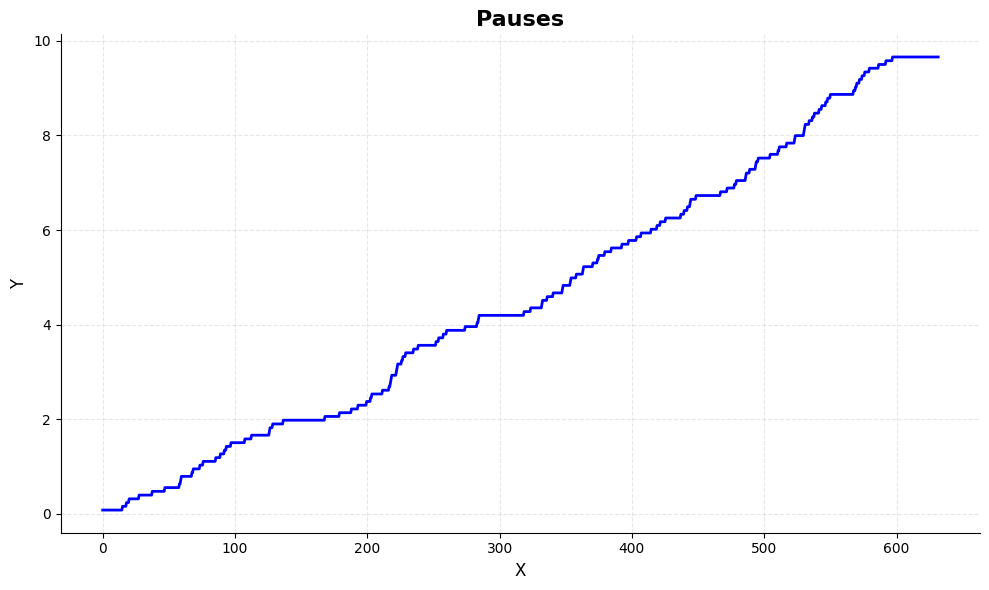

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Pauses'}, xlabel='X', ylabel='Y'>)

In [35]:
plot_beautiful(x=avw_merged_copy['Time'], y=avw_merged_copy['pause_percent_pr'], title="Pauses")

Pauses are also done

Let's save this version of the data

In [36]:
# path = project_root / "data" / "processed" / "merge" / "avw_merged_2.parquet"
# save_df_parquet_safe(df=avw_merged_copy, path=str(path))

## Isolation Forest for Anomaly Detection

In [37]:
from sklearn.ensemble import IsolationForest
import seaborn as sns

In [38]:
n_estimators = 100
contamination = 'auto'
sample_size = 256

Let's get some features ready

In [39]:
avw_merged_copy['h_ratio'][avw_merged_copy['h_ratio'].isna()]

1073   NaN
Name: h_ratio, dtype: float64

In [40]:
avw_merged_copy.loc[1073]

Time                                   536.5
words                                   None
text_concat                                 
h_ratio                                  NaN
v_ratio                                  NaN
                                     ...    
audio_pitch_var(expressiveness)         3.48
is_silent                              False
speaker                                    B
filler_percentage                  11.533505
pause_percent_pr                    8.392716
Name: 1073, Length: 64, dtype: object

In [41]:
avw_merged_copy.ffill(inplace=True)

In [42]:
avw_merged_copy.loc[1072] == avw_merged_copy.loc[1073]

Time                               False
words                               True
text_concat                        False
h_ratio                             True
v_ratio                             True
                                   ...  
audio_pitch_var(expressiveness)    False
is_silent                           True
speaker                             True
filler_percentage                   True
pause_percent_pr                   False
Length: 64, dtype: bool

In [43]:
avw_merged_copy.columns

Index(['Time', 'words', 'text_concat', 'h_ratio', 'v_ratio', '_neutral',
       'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft',
       'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight',
       'eyeBlinkLeft', 'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight',
       'eyeLookInLeft', 'eyeLookInRight', 'eyeLookOutLeft', 'eyeLookOutRight',
       'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight',
       'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen',
       'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight',
       'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft',
       'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPressLeft',
       'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower',
       'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper',
       'mouthSmileLeft', 'mouthSmileRight', 'mouthStretchLeft',
       'mouthStretchRight', 'mouthUpperUpLeft', 'mo

In [137]:
avw_merged_copy.loc[avw_merged_copy['speaker'] == 'B']

,Time,words,text_concat,h_ratio,v_ratio,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,...,mouthUpperUpRight,noseSneerLeft,noseSneerRight,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent,speaker,filler_percentage,pause_percent_pr
23,11.5,[[*]],[*],0.714017,-0.114366,3.417869e-07,0.038588,0.054834,0.007923,0.128693,...,0.000266,0.000010,6.323600e-07,0.0972,154.19,9.67,False,B,0.064433,0.079177
24,12.0,[[*]],,0.728435,-0.142492,3.132464e-07,0.045179,0.040908,0.009608,0.118403,...,0.000091,0.000007,5.223714e-07,0.0231,152.76,2.12,False,B,0.064433,0.079177
25,12.5,[right],right,0.783804,-0.148645,5.088546e-07,0.079663,0.090086,0.012937,0.072366,...,0.000735,0.000004,1.823347e-06,0.0619,0.00,0.00,False,B,0.064433,0.079177
26,13.0,"[now, I'm]",now I'm,0.449759,-0.032483,2.824809e-07,0.005977,0.009660,0.009890,0.279880,...,0.001296,0.000004,3.663175e-07,0.1176,166.37,4.43,False,B,0.064433,0.079177
27,13.5,"[in, third]",in third,0.516858,-0.076537,4.033183e-07,0.003955,0.003861,0.044342,0.321349,...,0.000221,0.000002,4.961004e-07,0.0772,149.59,7.99,False,B,0.064433,0.079177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,601.5,"[working, with, here.]",,0.495651,0.067600,6.775275e-07,0.013695,0.025590,0.008927,0.295969,...,0.000024,0.000005,3.997654e-07,0.0000,0.00,0.00,True,B,13.466495,9.659541
1204,602.0,"[working, with, here.]",,0.498080,0.033213,6.173227e-07,0.016473,0.023250,0.005833,0.294724,...,0.000021,0.000004,3.649026e-07,0.0000,0.00,0.00,True,B,13.466495,9.659541
1205,602.5,"[working, with, here.]",,0.506422,0.029738,4.996515e-07,0.016555,0.025004,0.005882,0.290684,...,0.000019,0.000005,3.498645e-07,0.0000,0.00,0.00,True,B,13.466495,9.659541
1206,603.0,"[working, with, here.]",,0.504315,0.030850,3.974955e-07,0.017760,0.028644,0.006066,0.295562,...,0.000015,0.000004,3.193707e-07,0.0000,0.00,0.00,True,B,13.466495,9.659541


In [1]:
features = avw_merged_copy[['h_ratio', 'v_ratio']]

NameError: name 'avw_merged_copy' is not defined

In [ ]:
# features = avw_merged_copy.loc[avw_merged_copy['speaker'] == 'B'][['audio_rms(volumn)',
#        'audio_pitch_avg', 'audio_pitch_var(expressiveness)']]

In [330]:
f_id = features.index

In [331]:
features.shape

(1264, 52)

In [332]:
features.head()

,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,browOuterUpRight,cheekPuff,cheekSquintLeft,cheekSquintRight,eyeBlinkLeft,...,mouthShrugLower,mouthShrugUpper,mouthSmileLeft,mouthSmileRight,mouthStretchLeft,mouthStretchRight,mouthUpperUpLeft,mouthUpperUpRight,noseSneerLeft,noseSneerRight
0,3.112116e-06,0.015592,0.025971,0.023290,0.123947,0.063837,0.000056,1.106405e-07,3.659683e-07,0.523586,...,0.177659,0.007289,0.000375,0.000198,0.000144,0.000443,0.000025,0.000022,4.540787e-07,4.185384e-07
1,2.558370e-06,0.017408,0.037184,0.007811,0.137800,0.031154,0.000021,1.167004e-07,3.605929e-07,0.169912,...,0.431183,0.019506,0.000308,0.000286,0.000198,0.000918,0.000023,0.000030,2.511999e-07,3.643879e-07
2,3.958608e-07,0.008864,0.010406,0.016732,0.179330,0.108023,0.000003,3.609665e-08,6.806206e-08,0.254797,...,0.083268,0.029491,0.000104,0.000074,0.000128,0.000332,0.000189,0.000269,2.899701e-06,1.134860e-07
3,3.260218e-07,0.012983,0.016629,0.008106,0.186212,0.116366,0.000003,4.715133e-08,7.834778e-08,0.230355,...,0.058299,0.018650,0.000008,0.000005,0.000032,0.000170,0.000070,0.000103,2.350217e-06,9.529118e-08
4,5.068692e-07,0.016363,0.028436,0.006705,0.117622,0.104900,0.000002,1.024494e-07,1.477437e-07,0.372640,...,0.073318,0.056317,0.000066,0.000058,0.000091,0.001666,0.000455,0.000476,4.304491e-06,2.317813e-07


In [227]:
# let's fit the model
iso_forest = IsolationForest(
    n_estimators=n_estimators,
    contamination=contamination,
    max_samples=sample_size,
    random_state=101
)

iso_forest.fit(features)

,n_estimators,100
,max_samples,256
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,101
,verbose,0
,warm_start,False


In [228]:
scores = iso_forest.decision_function(features)

In [229]:
results = iso_forest.predict(features)

In [230]:
type(scores), len(scores), scores.shape

(numpy.ndarray, 1079, (1079,))

In [231]:
type(results), len(results), results.shape

(numpy.ndarray, 1079, (1079,))

In [232]:
test = pd.DataFrame(scores, columns=['scores'], index=f_id)

In [233]:
test

,scores
23,-0.154376
24,-0.154376
25,-0.154376
26,-0.154376
27,-0.154376
...,...
1203,-0.112830
1204,-0.112830
1205,-0.112830
1206,-0.112830


In [234]:
test['anomalies'] = results

In [235]:
test

,scores,anomalies
23,-0.154376,-1
24,-0.154376,-1
25,-0.154376,-1
26,-0.154376,-1
27,-0.154376,-1
...,...,...
1203,-0.112830,-1
1204,-0.112830,-1
1205,-0.112830,-1
1206,-0.112830,-1


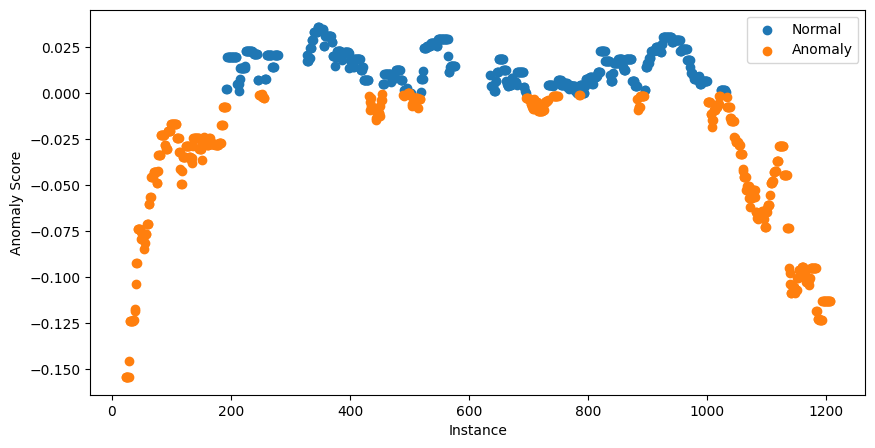

In [236]:
# Visualization of the results
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = test[test['anomalies'] == 1]
plt.scatter(normal.index, normal['scores'], label='Normal')

# Plot anomalies
anomalies = test[test['anomalies'] == -1]
plt.scatter(anomalies.index, anomalies['scores'], label='Anomaly')
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

let's test if how they perform by comparing to the actual frame images

In [237]:
test.loc[test['anomalies'] == -1]

,scores,anomalies
23,-0.154376,-1
24,-0.154376,-1
25,-0.154376,-1
26,-0.154376,-1
27,-0.154376,-1
...,...,...
1203,-0.112830,-1
1204,-0.112830,-1
1205,-0.112830,-1
1206,-0.112830,-1


In [238]:
anomalies = avw_merged.loc[test[test['anomalies'] == -1].index]
normal = avw_merged.loc[test[test['anomalies'] == 1].index]

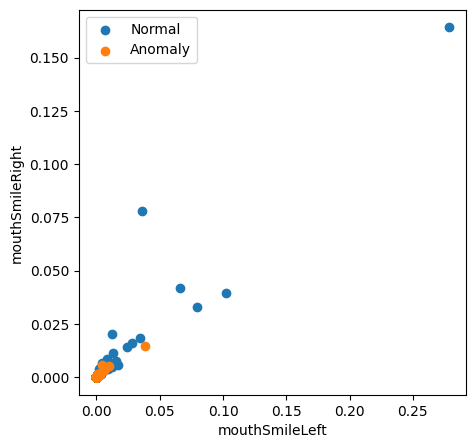

In [151]:
# Visualization of the results
plt.figure(figsize=(5, 5))

# Plot non-anomalies then anomalies
plt.scatter(normal['mouthSmileLeft'], normal['mouthSmileRight'], label='Normal')
plt.scatter(anomalies['mouthSmileLeft'], anomalies['mouthSmileRight'], label='Anomaly')
plt.xlabel("mouthSmileLeft")
plt.ylabel("mouthSmileRight")
plt.legend()
plt.show()

In [239]:
anomalies.shape, normal.shape

((480, 62), (599, 62))

In [241]:
anomalies['Time'].head()

23    11.5
24    12.0
25    12.5
26    13.0
27    13.5
Name: Time, dtype: float64

OK, Let's Try LOF

In [155]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

In [187]:
features

,h_ratio,v_ratio
0,0.463844,0.012997
1,0.418074,-0.048988
2,0.465044,-0.030748
3,0.505119,-0.055033
4,0.590369,-0.050514
...,...,...
1259,0.468203,0.012222
1260,0.464919,0.013546
1261,0.475860,0.006586
1262,0.481551,-0.023170


In [188]:
f_idx = features.index

In [189]:
# standerdizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [190]:
features_scaled

array([[-0.77055463,  1.05730146],
       [-1.57500197,  0.1938931 ],
       [-0.74947554,  0.4479631 ],
       ...,
       [-0.55936514,  0.96799385],
       [-0.45934306,  0.55351911],
       [-0.23045148,  0.67588689]], shape=(1264, 2))

In [191]:
# fitting the model
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination='auto',
    metric='euclidean'
)

# fit + predict
y_pred = lof.fit_predict(features_scaled)

In [192]:
features_scaled = pd.DataFrame(features_scaled, index=f_idx, columns=['h_ratio', 'v_ratio'])

In [193]:
features_scaled

,h_ratio,v_ratio
0,-0.770555,1.057301
1,-1.575002,0.193893
2,-0.749476,0.447963
3,-0.045115,0.109683
4,1.453204,0.172632
...,...,...
1259,-0.693942,1.046495
1260,-0.751671,1.064941
1261,-0.559365,0.967994
1262,-0.459343,0.553519


In [194]:
# outlier scores
lof_scores = -lof.negative_outlier_factor_

In [195]:
# getting the outliers
outlier_idx = np.where(y_pred == -1)[0]

In [196]:
outlier_idx

array([  23,   99,  114,  120,  173,  193,  209,  237,  238,  322,  423,
        424,  425,  443,  471,  474,  475,  520,  529,  530,  726,  755,
        772,  789,  811,  864,  881,  884,  962,  963, 1116, 1250])

In [197]:
outliers = features_scaled.iloc[outlier_idx]

In [198]:
outliers.shape

(32, 2)

In [199]:
outliers.head()

,h_ratio,v_ratio
23,3.626413,-0.716769
99,-2.786280,-0.283451
114,0.606940,1.559432
120,-0.815499,-0.514126
173,1.228073,0.908315


In [200]:
avw_merged_copy.loc[outliers.index, 'Time']

23       11.5
99       49.5
114      57.0
120      60.0
173      86.5
193      96.5
209     104.5
237     118.5
238     119.0
322     161.0
423     211.5
424     212.0
425     212.5
443     221.5
471     235.5
474     237.0
475     237.5
520     260.0
529     264.5
530     265.0
726     363.0
755     377.5
772     386.0
789     394.5
811     405.5
864     432.0
881     440.5
884     442.0
962     481.0
963     481.5
1116    558.0
1250    625.0
Name: Time, dtype: float64

In [333]:
f_id

RangeIndex(start=0, stop=1264, step=1)

In [334]:
features = features.to_numpy()
features

array([[3.11211647e-06, 1.55921420e-02, 2.59709526e-02, ...,
        2.16900535e-05, 4.54078730e-07, 4.18538377e-07],
       [2.55837040e-06, 1.74080487e-02, 3.71843018e-02, ...,
        3.03964462e-05, 2.51199879e-07, 3.64387915e-07],
       [3.95860809e-07, 8.86399485e-03, 1.04062073e-02, ...,
        2.69437529e-04, 2.89970080e-06, 1.13485953e-07],
       ...,
       [3.65660981e-07, 6.64923666e-03, 6.21082913e-03, ...,
        9.35548815e-05, 4.11035262e-06, 1.93315984e-07],
       [3.57996981e-07, 1.06849894e-02, 9.42121074e-03, ...,
        5.65406226e-05, 3.50592973e-06, 1.97342658e-07],
       [3.68229195e-07, 6.81659346e-03, 7.84811378e-03, ...,
        6.66497581e-05, 3.39339408e-06, 1.89214049e-07]], shape=(1264, 52))

In [ ]:
from pysad.models import RobustRandomCutForest
from pysad.utils import ArrayStreamer

# 2. Initialize Model
# We set shingle_size=1 here because PySAD expects 'X' to already be features.
# If you want temporal context, you should pre-process 'data' into windows.
model = RobustRandomCutForest(num_trees=40, tree_size=256, shingle_size=1)

# 3. Streaming Loop
# ArrayStreamer simulates a live stream from a static array
streamer = ArrayStreamer(shuffle=False)

anomaly_scores = []

for X in streamer.iter(features):
    # fit_score_partial updates the model AND returns the score in one step
    score = model.fit_score_partial(X)
    anomaly_scores.append(score)

print(f"Processed {len(anomaly_scores)} points.")
print(f"Max Anomaly Score: {max(anomaly_scores):.2f}")

Processed 1264 points.
Max Anomaly Score: 78.53


In [336]:
anomaly_scores

[0.0,
 1.0000000000000004,
 1.4249999999999998,
 1.2999999999999996,
 1.9999999999999998,
 1.5583333333333331,
 1.8333333333333335,
 2.7312499999999993,
 1.8520833333333333,
 2.152083333333333,
 1.5341666666666667,
 3.770833333333333,
 3.768749999999999,
 1.8991666666666671,
 2.67172619047619,
 1.7249999999999999,
 6.224464285714286,
 3.3137499999999998,
 2.724583333333334,
 2.242410714285715,
 5.392083333333332,
 2.490109126984127,
 10.841666666666669,
 5.241011904761906,
 3.5424630230880227,
 5.099563492063492,
 4.628510378510381,
 3.020860042735042,
 6.070615079365078,
 3.02626984126984,
 2.2897369297369297,
 3.550972222222222,
 6.047411616161616,
 6.757102029914531,
 4.0196347402597405,
 3.1632873376623367,
 3.4418861551030657,
 1.7549828908836262,
 2.408886738261738,
 2.7092794011544004,
 2.070837773337773,
 2.0057456140350873,
 4.633125000000001,
 7.766124401913875,
 12.002325174825174,
 4.920892857142858,
 7.662871891180712,
 3.206446041703394,
 2.444755114166878,
 12.6391125541

In [337]:
anomalies = pd.DataFrame(anomaly_scores, index=f_id, columns=['anomaly_scores'])

In [338]:
anomalies

,anomaly_scores
0,0.000000
1,1.000000
2,1.425000
3,1.300000
4,2.000000
...,...
1259,4.346452
1260,3.351935
1261,3.862557
1262,3.161283


In [339]:
def get_threshold_mad(scores, n_sigma=3):
    """
    Robust Z-Score method using Median and MAD.
    Standard Z-Score = (x - mean) / std
    Robust Z-Score = (x - median) / (1.4826 * MAD)
    """
    scores = np.array(scores)
    median = np.median(scores)
    
    # Calculate MAD (Median Absolute Deviation)
    mad = np.median(np.abs(scores - median))
    
    # The factor 1.4826 makes MAD comparable to Standard Deviation for normal data
    consistent_mad = 1.4826 * mad
    
    # Threshold = Median + (3 * Robust_Std_Dev)
    threshold = median + (n_sigma * consistent_mad)
    return threshold

# Usage
thresh = get_threshold_mad(anomaly_scores, n_sigma=3)
print(f"MAD Threshold: {thresh}")

MAD Threshold: 16.364147951429917


In [340]:
anomalies[anomalies['anomaly_scores'] > thresh].shape

(117, 1)

In [349]:
times = avw_merged_copy.loc[anomalies[anomalies['anomaly_scores'] > thresh].index, ['Time']]

In [342]:
def secs_mins(secs):
    mins = secs / 60
    if mins < 1:
        return mins*60
    else:
        sec = (mins - (secs // 60))*60
        mins = str(int((secs // 60))) + ":" + str(round(sec))
        return mins

In [343]:
secs_mins(72)

'1:12'

In [350]:
times['Time'].iloc[30:50]

508    254.0
509    254.5
519    259.5
524    262.0
537    268.5
556    278.0
560    280.0
574    287.0
575    287.5
576    288.0
577    288.5
578    289.0
579    289.5
580    290.0
581    290.5
582    291.0
583    291.5
586    293.0
587    293.5
588    294.0
Name: Time, dtype: float64

In [344]:
times['Time'].apply(func=secs_mins)

84     42.0
114    57.0
135     1:8
203    1:42
209    1:44
285    2:22
286    2:23
287    2:23
303    2:31
304    2:32
305    2:32
328    2:44
329    2:44
330    2:45
333    2:46
334    2:47
335    2:47
336    2:48
345    2:52
364     3:2
369     3:5
431    3:36
445    3:43
446    3:43
461    3:51
464    3:52
465    3:52
466    3:53
489     4:5
502    4:11
Name: Time, dtype: object